In [4]:
import pandas as pd
import numpy as np
from tkinter import filedialog
from tkinter import *
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import io
import os

In [6]:
# Step 1: Load Data Function
def manualloadfile():
    folderpath = ""

    root = Tk()
    root.filename = filedialog.askopenfilename(
        initialdir=folderpath, 
        title="Select file", 
        filetypes=(("R1R files", "*.r1r"), ("all files", "*.*"))
    )
    print(root.filename)
    
    #data = pd.read_csv(root.filename)
    
    # Open the file and read lines
    with open(root.filename, 'r') as file:
        # Read all lines
        lines = file.readlines()
        
        # Find the index of the first line containing 'Test #'
        try:
            start_index = next(i for i, line in enumerate(lines) if line.startswith('Test #'))
        except StopIteration:
            start_index = -1  # Handle case where 'Test #' is not found
        
        # Filter lines from 'Test #' onwards
        filtered_content = lines[start_index:]
        
    # Now load filtered content into DataFrame
    data = pd.read_csv(io.StringIO(''.join(filtered_content)))
    
    # Convert 'V ref (mV)' column to numeric
    data['V ref (mV)'] = pd.to_numeric(data['V ref (mV)'], errors='coerce')
    data['P0T0 (uA)'] = pd.to_numeric(data['P0T0 (uA)'], errors='coerce')
    
    print(data)
    root.destroy()
    
    return data, root.filename

# Load the data
data, filename = manualloadfile()

# Find the index of the row that contains 'Test #' in any column
#start_index = data[data.apply(lambda row: row.astype(str).str.contains('Test #').any(), axis=1)].index[0]

# Include rows starting from 'Test #' onwards including the row that has 'Test #'
#data = data.iloc[start_index:].reset_index(drop=True)

# Drop the first 50 rows as specified
#data = data.drop(range(0, 50), axis=0).reset_index(drop=True)

# Drop the first 50 rows if there are enough rows
if len(data) > 50:
    data = data.iloc[50:].reset_index(drop=True)

#else:
#    data = data.reset_index(drop=True)

# Initialize the dictionaries for forward and backward sweeps
#sweeps = {'forward_sweep': [], 'backward_sweep': []}

forwardSweep = []
backwardSweep = []
forwardSweep.append([])
backwardSweep.append([])
counter_sweep = 0
fm = 0
bm = 0

# Loop through the data to calculate differences and sort into sweeps
for i in range(1, len(data)):
    diff = data['V ref (mV)'].iloc[i] - data['V ref (mV)'].iloc[i-1]
    
    if diff > 0:
        
        if counter_sweep == 1:
            fm = fm + 1
            counter_sweep = 0
            forwardSweep.append([])  # Start a new forward sweep
        
        forwardSweep[fm].append(i)
        
    else:
        if counter_sweep == 0:
            bm = bm + 1
            counter_sweep = 1
            backwardSweep.append([])  # Start a new backward sweep
        
        backwardSweep[bm].append(i)

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(data['V ref (mV)'], data['P0T0 (uA)'], label='Data 1')
plt.xlabel('V ref (mV)')
plt.ylabel('P0T0 (uA)')
plt.title('Data Plot')
plt.legend()
plt.show()

# Ensure forward and backward sweeps have the same number of elements for DataFrame creation
max_length = max(len(forwardSweep), len(backwardSweep))
forward_sweep_data = [','.join(map(str, fs)) for fs in forwardSweep] + [''] * (max_length - len(forwardSweep))
backward_sweep_data = [','.join(map(str, bs)) for bs in backwardSweep] + [''] * (max_length - len(backwardSweep))

sweeps_df = pd.DataFrame({
    'forward_sweep': forward_sweep_data,
    'backward_sweep': backward_sweep_data
})

# Define the directory where you want to save the file
base_directory = os.path.dirname(filename)
save_directory = os.path.join(base_directory, 'forward_backward_sweeps')

# Ensure the directory exists
os.makedirs(save_directory, exist_ok=True)

output_filename = os.path.join(save_directory, os.path.splitext(os.path.basename(filename))[0] + '_forward_backward_sweeps.csv')
sweeps_df.to_csv(output_filename, index=False)

2024-06-27 15:47:04.654 Python[32584:7425975] +[CATransaction synchronize] called within transaction
2024-06-27 15:47:04.674 Python[32584:7425975] +[CATransaction synchronize] called within transaction
2024-06-27 15:47:09.777 Python[32584:7425975] +[CATransaction synchronize] called within transaction


FileNotFoundError: [Errno 2] No such file or directory: ''

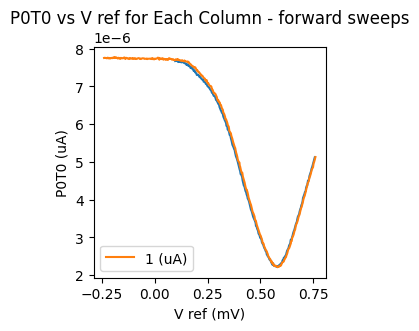

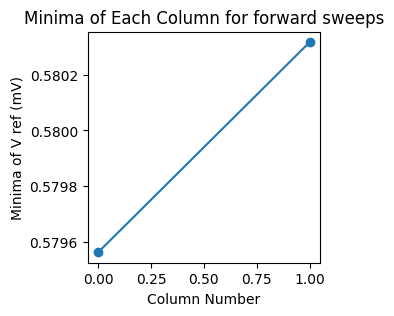

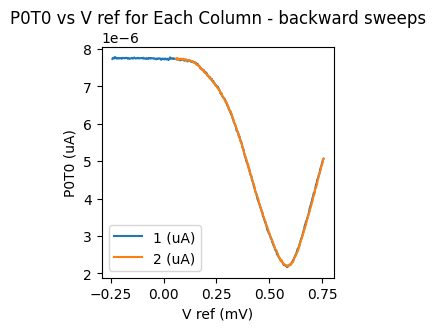

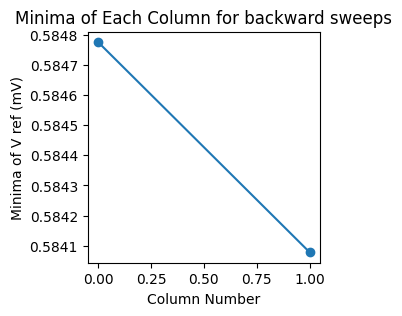

In [3]:
#Finding and plotting dirac voltages using the minima of each plot

plt.figure(figsize=(3, 3))

num_columns = len(forwardSweep)

# Initialize lists to store minima and corresponding V ref values
minima = []
v_ref_at_minima = []

# Plotting every column
for n in range( num_columns):
    if n == 1 or n == num_columns-1:
        plt.plot(data['V ref (mV)'].iloc[forwardSweep[n]], data[f'P0T0 (uA)'].iloc[forwardSweep[n]], label=f'{n} (uA)')
    else:
        plt.plot(data['V ref (mV)'].iloc[forwardSweep[n]], data[f'P0T0 (uA)'].iloc[forwardSweep[n]])
    # Find the index of the minimum value in P0T0
    col_min_idx = data[f'P0T0 (uA)'].iloc[forwardSweep[n]].idxmin()
    # Get the minimum value and the corresponding V ref
    col_min = data[f'P0T0 (uA)'].iloc[col_min_idx]
    v_ref_min = data['V ref (mV)'].iloc[col_min_idx]
    minima.append(col_min)
    #print(minima)
    v_ref_at_minima.append(v_ref_min)

plt.xlabel('V ref (mV)')
plt.ylabel('P0T0 (uA)')
plt.legend(loc=3)#, prop={'size': 6})
plt.title('P0T0 vs V ref for Each Column - forward sweeps')
plt.show()

# Plotting the minima against the column number
plt.figure(figsize=(3, 3))
plt.plot(range(num_columns), v_ref_at_minima, 'o-')
plt.xlabel('Column Number')
plt.ylabel('Minima of V ref (mV)')
plt.title('Minima of Each Column for forward sweeps')
plt.show()

num_columns = len(backwardSweep)

# Initialize lists to store minima and corresponding V ref values
minima = []
v_ref_at_minima = []

# Plotting every column
plt.figure(figsize=(3, 3))
for n in range(1, num_columns):
    if n == 1 or n == num_columns-1:
        plt.plot(data['V ref (mV)'].iloc[backwardSweep[n]], data[f'P0T0 (uA)'].iloc[backwardSweep[n]], label=f'{n} (uA)')
    else:
        plt.plot(data['V ref (mV)'].iloc[backwardSweep[n]], data[f'P0T0 (uA)'].iloc[backwardSweep[n]])#, label=f'{n} (uA)')
    # Find the index of the minimum value in P0T0
    col_min_idx = data[f'P0T0 (uA)'].iloc[backwardSweep[n]].idxmin()
    # Get the minimum value and the corresponding V ref
    col_min = data[f'P0T0 (uA)'].iloc[col_min_idx]
    v_ref_min = data['V ref (mV)'].iloc[col_min_idx]
    minima.append(col_min)
    #print(minima)
    v_ref_at_minima.append(v_ref_min)

plt.xlabel('V ref (mV)')
plt.ylabel('P0T0 (uA)')
plt.legend(loc=3)#, prop={'size': 6})
plt.title('P0T0 vs V ref for Each Column - backward sweeps')
plt.show()

# Plotting the minima against the column number
plt.figure(figsize=(3, 3))
plt.plot(range(num_columns-1), v_ref_at_minima, 'o-')
plt.xlabel('Column Number')
plt.ylabel('Minima of V ref (mV)')
plt.title('Minima of Each Column for backward sweeps')
plt.show()
